In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df = pd.read_csv('combined_all.csv')
df.fillna('', inplace=True)
df.head()

,public_id,title,text,our rating
0,f2182a54,HUGE! Attorney Sidney Powell CONFIRMS Alleged ...,Last week Rep. Louie Gohmert told Chris Salced...,false
1,c5175d8d,Paul Ryan’s Worst Ally - The New York Times,WHATEVER drama plays out when Republicans meet...,true
2,213a870b,"You Can Get Jail Time Or $3,000 Fine For Not W...",Source page URL Title You Can Get Jail Time O...,false
3,392886ea,Antifa gearing up for false flag violence disg...,With merchants in Democrat-run cities boarding...,false
4,bc6d5d55,Remarks by President Biden on the Administrati...,State Dining Room 4:22 P.M. EST THE PRESIDEN...,partially false


In [4]:
X = df.drop('our rating', axis=1)
y = df['our rating']

X['total'] = X['title'] + ' ' + X['text']

encode = {"false": 0,
          "true": 1,
          "partially false": 2,
          "other": 3
          }

y = y.replace(encode)
print(y.value_counts())

0    485
2    237
1    152
3     76
Name: our rating, dtype: int64


In [5]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [6]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LeakyReLU

In [7]:
words = X.copy()

In [8]:
import nltk
import re
from nltk.corpus import stopwords

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [10]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()
corpus = []

for i in range(len(words)):
  review = re.sub('[^a-zA-Z]', ' ', words['total'].iloc[i])
  review = review.lower()
  review = review.split()
  review = [word for word in review 
            if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus.append(review)

In [11]:
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
word_index = tokenizer.word_index
max_len = max([len(x) for x in sequences])
len(word_index)

27401

In [12]:
data = pad_sequences(sequences, padding='post', maxlen=max_len)
data[420]

array([   8, 4701,   29, ...,    0,    0,    0], dtype=int32)

In [13]:
embeddings_index = {}
GLOVE_DIR = '/content/drive/MyDrive/Fake News Detection AI-Two/glove.6B.100d.txt'
EMBEDDING_DIM = 100

with open(GLOVE_DIR, 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
  else:
    embedding_matrix[i] = np.random.randn(EMBEDDING_DIM)

In [14]:
model = Sequential()
model.add(Embedding(len(word_index)+1, EMBEDDING_DIM,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=True))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3228, 100)         2740200   
_________________________________________________________________
bidirectional (Bidirectional (None, 3228, 128)         84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 2,866,156
Trainable params: 2,866,156
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
X_processed = np.array(data)
y_processed = np.array(y)

X_processed.shape, y_processed.shape

((950, 3228), (950,))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, 
                                                    test_size=0.2, random_state=42)

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, verbose= 0, patience=2, mode='auto')
# history = model.fit(X_train, y_train, validation_split=0.1, epochs=5, batch_size=32)
history = model.fit(X_train, y_train, validation_split=0.1, callbacks=[callback], epochs=5, batch_size=32)

Epoch 1/5
22/22 [==============================] - 221s 10s/step - loss: 1.2352 - accuracy: 0.4766 - val_loss: 1.2266 - val_accuracy: 0.4868
Epoch 2/5
22/22 [==============================] - 215s 10s/step - loss: 1.1397 - accuracy: 0.5233 - val_loss: 1.2090 - val_accuracy: 0.5395
Epoch 3/5
22/22 [==============================] - 215s 10s/step - loss: 0.9912 - accuracy: 0.6010 - val_loss: 1.2315 - val_accuracy: 0.4737
Epoch 4/5
22/22 [==============================] - 227s 10s/step - loss: 0.8743 - accuracy: 0.6633 - val_loss: 1.2078 - val_accuracy: 0.5789
Epoch 5/5
22/22 [==============================] - 226s 10s/step - loss: 0.6945 - accuracy: 0.7168 - val_loss: 1.3177 - val_accuracy: 0.5395


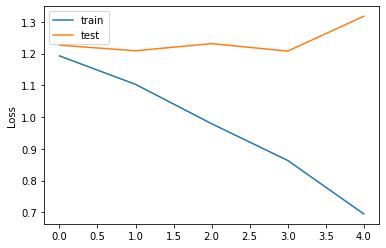

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel=('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

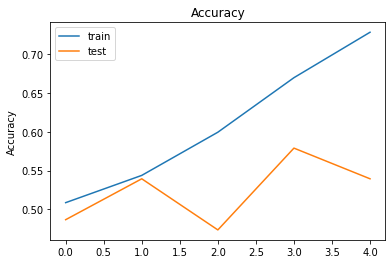

In [19]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel=('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
pred = model.predict_classes(X_test)
pred

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 2, 0, 2, 0, 1, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0,
       2, 2, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2,
       0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 2,
       0, 1, 2, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0,
       0, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0,
       1, 1, 0, 0, 2, 2, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2,
       0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 1, 2])

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [22]:
print(classification_report(y_test, pred, zero_division=False))

              precision    recall  f1-score   support

           0       0.58      0.73      0.64        92
           1       0.43      0.11      0.18        27
           2       0.46      0.58      0.52        53
           3       0.00      0.00      0.00        18

    accuracy                           0.53       190
   macro avg       0.37      0.36      0.33       190
weighted avg       0.47      0.53      0.48       190



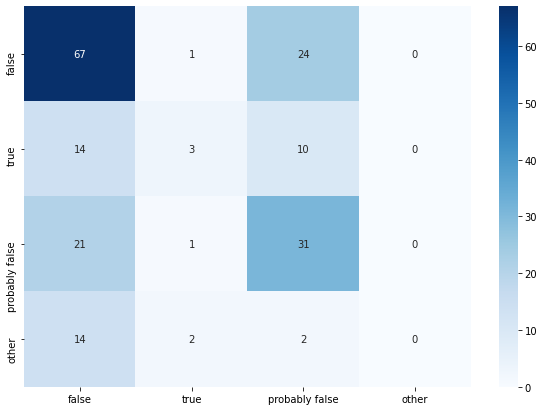

In [23]:
import seaborn as sn
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=['false', 'true', 'probably false', 'other'], 
                     columns=['false', 'true', 'probably false', 'other'])
plt.figure(figsize = (10, 7))
sn.heatmap(df_cm, cmap="Blues", annot=True)

In [24]:
test = pd.read_csv('Task3a_testing.csv')
test.fillna('', inplace=True)
test['total'] = test['title'] + ' ' + test['text']

In [25]:
words_test = test.copy()
corpus_test = []

for i in range(len(words_test)):
  review = re.sub('[^a-zA-Z]', ' ', words_test['total'].iloc[i])
  review = review.lower()
  review = review.split()
  review = [word for word in review 
            if not word in stopwords.words('english')]
  review = ' '.join(review)
  corpus_test.append(review)

In [26]:
sequences_test = tokenizer.texts_to_sequences(corpus_test)
max_len = max([len(x) for x in sequences_test])
data_test = np.array(pad_sequences(sequences_test, padding='post', maxlen=max_len))

In [27]:
predictions = model.predict_classes(data_test)
predictions

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 1, 0,
       2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 2,
       2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 2, 0, 2,
       0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 2, 0, 2, 0, 1, 0, 0, 2, 2, 2, 2, 0, 1, 2, 0, 2, 0, 2,
       0, 1, 0, 0, 0, 1, 2, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 1, 0, 2, 0, 2,
       2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 2, 2, 1, 0, 0, 0, 0, 2, 1, 2, 0, 2,
       0, 0, 1, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2,
       2, 2, 0, 0, 2, 0, 2, 1, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 1, 0,
       1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 2, 2, 0, 0, 1, 0, 2, 2, 0, 0, 0, 2,
       2, 1, 0, 0, 0, 0, 0, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0,

In [28]:
df_out = pd.DataFrame()
df_out['public_id'] = test['public_id']
df_out.shape, predictions.shape
df_out['predicted_rating'] = predictions

decode = {0: "false",
          1: "true",
          2: "partially false",
          3: "other"
          }

df_out = df_out.replace(decode)
df_out.head()
df_out.to_csv('predictions.csv', index=False)

In [30]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
